In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

In [3]:
df = pd.read_csv(path + "NYPD_Motor_Vehicle_Collisions.csv", parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

In [4]:
df['DAY_OF_WEEK'] = df['DATE_TIME'].dt.dayofweek
df['HOUR_OF_DAY'] = df['DATE_TIME'].dt.hour
df['MONTH'] = df['DATE_TIME'].dt.month

Loop through the directory

In [5]:
datasets = {}

for file in os.listdir(path+"data_for_joining/"):
    if file.endswith(".pkl"):
        with open(os.path.join(path+"data_for_joining/", file), 'rb') as pkl_file:
            datasets[file.strip(".pkl")] = pickle.load(pkl_file, encoding='latin1')

In [6]:
for key, value in datasets.items() :
    print (key)
    if "traffic" in key:
        datasets[key].name = datasets[key].name + '_' + key.split('_')[-1]
    df = df.join(datasets[key], on='UNIQUE KEY', how='left')

traffic_joined_0.005
subway_joined
311_joined
LightsComplaints
traffic_joined_0.002
Bank_Holidays
traffic_joined_0.003
daylight_joined
weather_joined_utm


In [7]:
renamed_columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    
df.columns = renamed_columns

In [8]:
df = df[df.latitude.notnull()]
df = df[df.longitude > -100]

In [9]:
df.columns.values

array(['date_time', 'borough', 'zip_code', 'latitude', 'longitude',
       'location', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'unique_key', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5',
       'day_of_week', 'hour_of_day', 'month', 'uber_count_0.005',
       'dist_to_closest_subway', 'congestion/gridlock_total_bin',
       'chronic_speeding_total_bin',
       'chronic_stoplight_violation_total_bin', 'drag_racing_total_bin',
       'truck_rout

In [10]:
integers = ['zip_code','number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'day_of_week', 'hour_of_day', 'lights_complaints',
        'bank_holiday_flag', 'rain', 'thunderstorm',
       'snow', 'fog', 'congestion/gridlock_total_bin', 'chronic_speeding_total_bin',
       'chronic_stoplight_violation_total_bin', 'drag_racing_total_bin',
       'truck_route_violation_total_bin',
       'congestion/gridlock_count_90_days_before',
       'chronic_speeding_count_90_days_before',
       'chronic_stoplight_violation_count_90_days_before',
       'drag_racing_count_90_days_before',
       'truck_route_violation_count_90_days_before',
        'uber_count_0.002', 'uber_count_0.003', 'uber_count_0.005']

In [11]:
floats = ['latitude', 'longitude','temperature', 'heat_index', 'dew_point', 'humidity', 'pressure',
       'visibility', 'wind_speed', 'gust_speed', 'precip', 'dist_to_closest_subway']

In [12]:
def to_int(x):
    try:
        return int(x)
    except:
        return np.nan

for column in integers:
    df[column] = df[column].apply(to_int)
df.loc[:, integers]

,zip_code,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,day_of_week,...,drag_racing_total_bin,truck_route_violation_total_bin,congestion/gridlock_count_90_days_before,chronic_speeding_count_90_days_before,chronic_stoplight_violation_count_90_days_before,drag_racing_count_90_days_before,truck_route_violation_count_90_days_before,uber_count_0.002,uber_count_0.003,uber_count_0.005
0,11205.0,0,0,0,0,0,0,0,0,1,...,0,0,3,0,0,0,0,0,3,11
1,NaN,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,4
2,NaN,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,70,128,390
3,11234.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7,11355.0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
8,10461.0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
9,11230.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17,10016.0,0,0,0,0,0,0,0,0,3,...,0,2,0,0,0,0,0,64,182,526
19,11204.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
for column in floats:
    df[column] = pd.to_numeric(df[column], errors='coerce')
df.loc[:, floats]

,latitude,longitude,temperature,heat_index,dew_point,humidity,pressure,visibility,wind_speed,gust_speed,precip,dist_to_closest_subway
0,40.697254,-73.961830,51.1,NaN,46.0,83.0,83.0,8.0,3.5,NaN,0.00,932.785445
1,40.795370,-73.921974,51.1,NaN,46.0,83.0,83.0,8.0,3.5,NaN,0.00,1282.222847
2,40.758644,-73.981346,51.1,NaN,46.0,83.0,83.0,8.0,3.5,NaN,0.00,18.717114
3,40.632847,-73.928375,46.9,NaN,44.1,90.0,90.0,9.0,12.7,NaN,0.01,1606.960019
4,40.732941,-73.920382,84.9,83.6,55.0,36.0,36.0,10.0,13.8,19.6,NaN,1133.786120
7,40.746902,-73.834694,50.0,NaN,45.0,83.0,83.0,10.0,6.9,NaN,0.00,1255.415361
8,40.842030,-73.849560,51.1,NaN,44.1,77.0,77.0,10.0,10.4,NaN,NaN,601.888498
9,40.624878,-73.964180,46.9,NaN,43.0,86.0,86.0,8.0,9.2,NaN,0.00,275.743942
17,40.745715,-73.986531,88.0,92.1,69.1,53.0,53.0,8.0,NaN,NaN,NaN,177.969540
19,40.627740,-73.981575,46.9,NaN,43.0,86.0,86.0,8.0,9.2,NaN,0.00,409.434844


In [14]:
df['conditions'].unique()

array(['Overcast', 'Light Rain', 'Scattered Clouds', 'Clear',
       'Mostly Cloudy', 'Partly Cloudy', 'Haze', 'Light Drizzle',
       'Unknown', 'Thunderstorm', 'Heavy Thunderstorms and Rain',
       'Light Snow', 'Fog', 'Rain', 'Mist', 'Light Freezing Rain',
       'Heavy Snow', 'Snow', 'Light Freezing Fog',
       'Light Thunderstorms and Rain', 'Thunderstorms and Rain',
       'Heavy Rain', 'Shallow Fog', 'Light Ice Pellets', 'Drizzle',
       'Light Freezing Drizzle', 'Ice Pellets', 'Blowing Snow',
       'Patches of Fog', 'Light Rain Showers', 'Widespread Dust',
       'Heavy Ice Pellets', 'Squalls', 'Thunderstorms with Small Hail'], dtype=object)

(0, 10000)

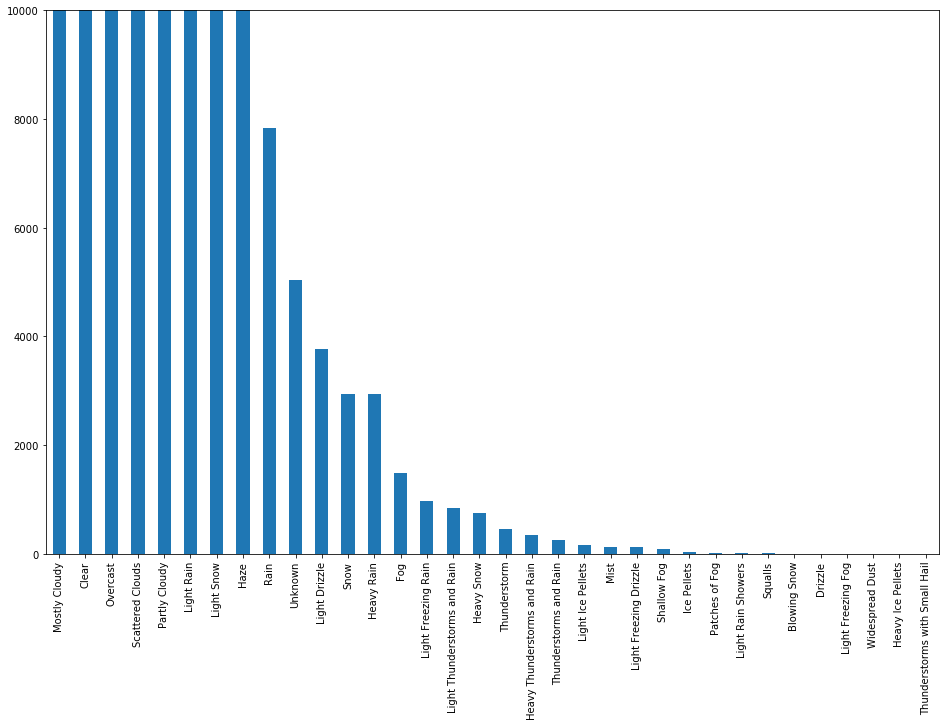

In [15]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

In [16]:
remap_weather = {'Heavy Snow': 'Snow',
                'Light Freezing Rain': 'Light Rain',
                'Heavy Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Ice Pellets': 'Ice Pellets',
                'Heavy Ice Pellets': 'Ice Pellets',
                'Thunderstorms with Small Hail': 'Thunderstorms and Rain',
                'Shallow Fog': 'Fog',
                'Light Freezing Fog': 'Fog',
                'Mist': 'Fog',
                'Blowing Snow': 'Snow',
                'Drizzle': 'Light Rain',
                'Widespread Dust': 'Haze',
                'Squalls': np.nan,
                'Unknown': np.nan,
                'Light Drizzle': 'Light Rain',
                'Light Freezing Drizzle': 'Light Rain',
                'Patches of Fog': 'Fog',
                'Light Rain Showers': 'Light Rain',
                }

df['conditions'].replace(to_replace=remap_weather, inplace=True)

(0, 10000)

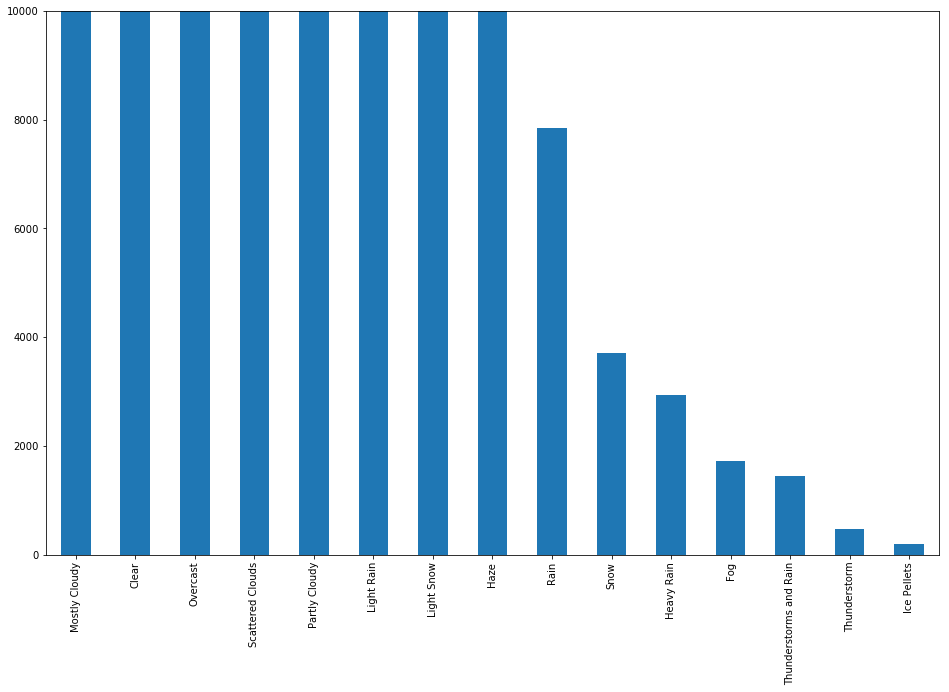

In [17]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

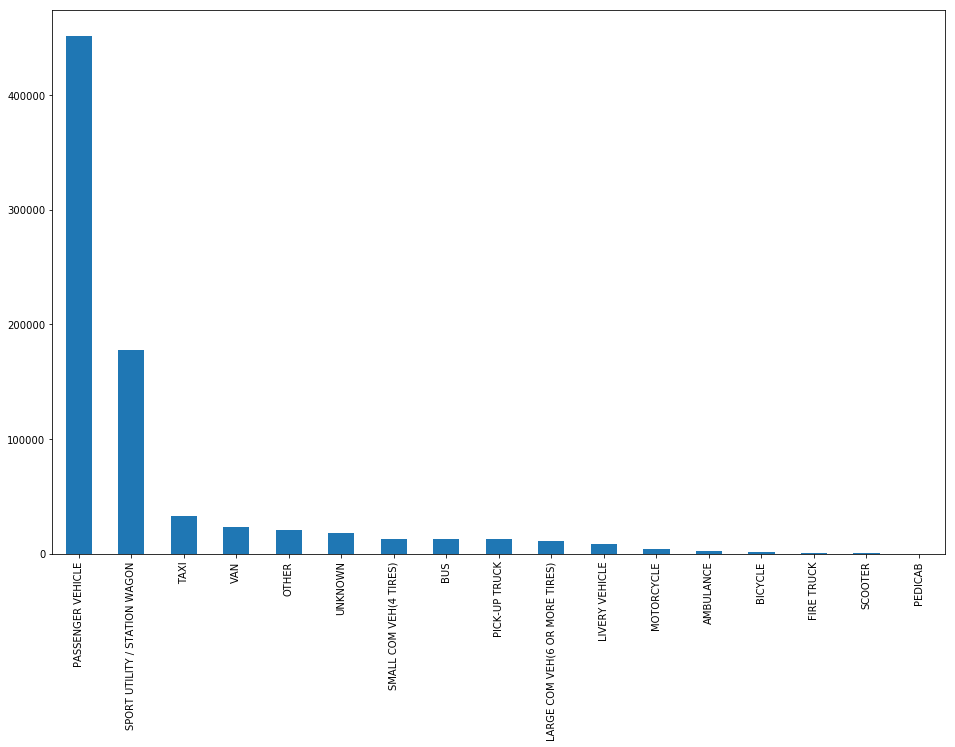

In [18]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [19]:
remap_vehicle = {'TAXI': 'SMALL COM VEH(4 TIRES)',
                'BUS': 'LARGE VEHICLE',
                'SCOOTER': 'MOTORCYCLE',
                'LIVERY VEHICLE': 'SMALL COM VEH(4 TIRES)',
                'VAN': 'MEDIUM VEHICLE',
                'PEDICAB': 'BICYCLE',
                'PICK-UP TRUCK': 'MEDIUM VEHICLE',
                'SPORT UTILITY / STATION WAGON': 'MEDIUM VEHICLE',
                'LARGE COM VEH(6 OR MORE TIRES)': 'LARGE VEHICLE',
                'FIRE TRUCK': 'LARGE VEHICLE',
                }

In [20]:
for column in ['vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']:
    df[column].replace(to_replace=remap_vehicle, inplace=True)

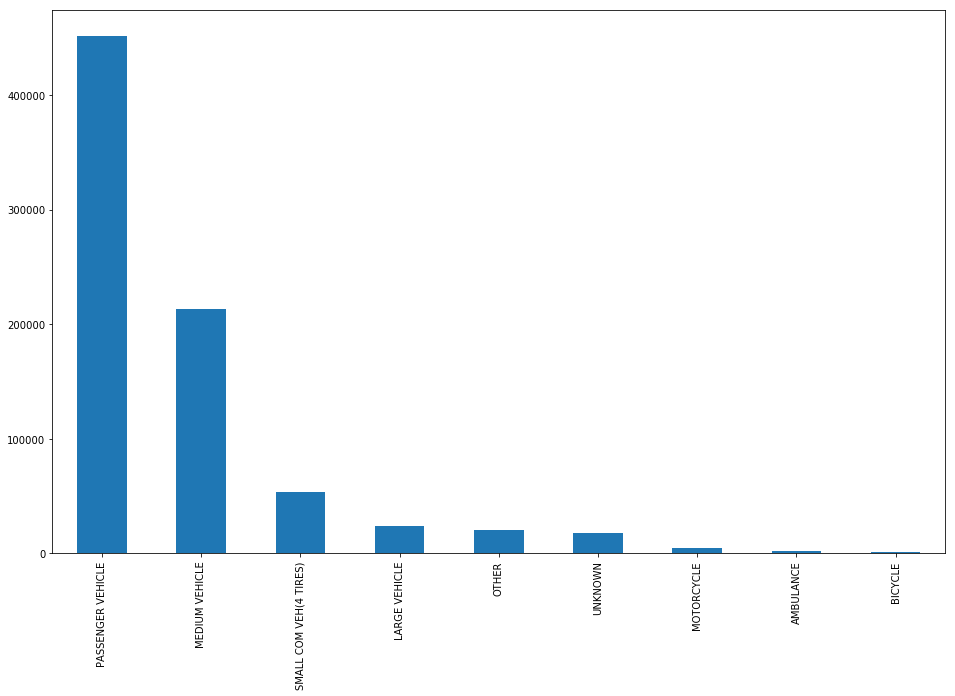

In [21]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [22]:
df = df.reset_index()

In [23]:
def all_vehicle_same(veh1, veh2, veh3, veh4, veh5):
    series = pd.Series([veh1, veh2, veh3, veh4, veh5]).dropna()
    if len(series.unique()) == 1 and len(series) != 1:
        return True
    else:
        return False
    

In [24]:
same_type = []

for idx, row in df.iterrows():
    same_type.append(all_vehicle_same(row.vehicle_type_code_1,\
                                    row.vehicle_type_code_2,\
                                    row.vehicle_type_code_3,\
                                    row.vehicle_type_code_4,\
                                    row.vehicle_type_code_5))
    
    if idx % 1000 == 0:
        print('%s/%s rows finished' % (idx, df.shape[0]))

0/792842 rows finished
1000/792842 rows finished
2000/792842 rows finished
3000/792842 rows finished
4000/792842 rows finished
5000/792842 rows finished
6000/792842 rows finished
7000/792842 rows finished
8000/792842 rows finished
9000/792842 rows finished
10000/792842 rows finished
11000/792842 rows finished
12000/792842 rows finished
13000/792842 rows finished
14000/792842 rows finished
15000/792842 rows finished
16000/792842 rows finished
17000/792842 rows finished
18000/792842 rows finished
19000/792842 rows finished
20000/792842 rows finished
21000/792842 rows finished
22000/792842 rows finished
23000/792842 rows finished
24000/792842 rows finished
25000/792842 rows finished
26000/792842 rows finished
27000/792842 rows finished
28000/792842 rows finished
29000/792842 rows finished
30000/792842 rows finished
31000/792842 rows finished
32000/792842 rows finished
33000/792842 rows finished
34000/792842 rows finished
35000/792842 rows finished
36000/792842 rows finished
37000/792842 r

In [25]:
df['all_vehicles_same_type'] = same_type

In [26]:
df['injured'] = (df.number_of_persons_injured+df.number_of_pedestrians_injured+\
                df.number_of_cyclist_injured+df.number_of_motorist_injured)>0
df['killed'] = (df.number_of_persons_killed+df.number_of_pedestrians_killed+\
                df.number_of_cyclist_killed+df.number_of_motorist_killed)>0
df['injured_or_killed'] = df.injured | df.killed

In [27]:
drop_columns = ['index', 'location', 'unique_key', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5']

In [28]:
df = df.drop(drop_columns, axis=1)

In [30]:
for column in df:
    if np.sum(df[column].isnull()) > 0:
        df[column+'_nan'] = df[column].isnull()
        
        if column == 'zip_code':
            df[column].fillna(df[column].mode(), inplace=True)
        elif column in df._get_numeric_data().columns.values:
            df[column].fillna(df[column].mean(), inplace=True)

In [31]:
finaldf = pd.get_dummies(df, columns=['borough', 'vehicle_type_code_1',
       'vehicle_type_code_2', 'vehicle_type_code_3', 'vehicle_type_code_4',
       'vehicle_type_code_5', 'wind_dir', 'conditions'])

In [32]:
finaldf.columns.values

array(['date_time', 'zip_code', 'latitude', 'longitude', 'day_of_week',
       'hour_of_day', 'month', 'uber_count_0.005',
       'dist_to_closest_subway', 'congestion/gridlock_total_bin',
       'chronic_speeding_total_bin',
       'chronic_stoplight_violation_total_bin', 'drag_racing_total_bin',
       'truck_route_violation_total_bin',
       'congestion/gridlock_count_90_days_before',
       'chronic_speeding_count_90_days_before',
       'chronic_stoplight_violation_count_90_days_before',
       'drag_racing_count_90_days_before',
       'truck_route_violation_count_90_days_before', 'lights_complaints',
       'uber_count_0.002', 'bank_holiday_flag', 'uber_count_0.003',
       'rise_time', 'set_time', 'sun_out', 'temperature', 'heat_index',
       'dew_point', 'humidity', 'pressure', 'visibility', 'wind_speed',
       'gust_speed', 'precip', 'rain', 'thunderstorm', 'snow', 'fog',
       'all_vehicles_same_type', 'injured', 'killed', 'injured_or_killed',
       'borough_nan', 'zip_

In [33]:
renamed_columns = [x.lower().replace(' ', '_') for x in finaldf.columns.values]
    
finaldf.columns = renamed_columns

In [35]:
with open("collisions.pkl", 'wb') as outfile:
    pickle.dump(finaldf, outfile)